In [1]:
import sys
import numpy as np
import torch

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Torch:", torch.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2
Torch: 2.9.0+cu126


Mounted at /content/drive
Number of drug–drug–side-effect triples: 4649441
Number of unique drugs: 645
Number of unique side-effect types: 1317


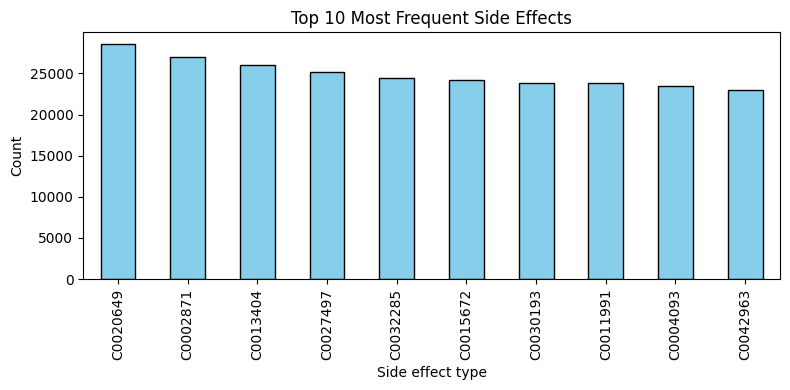

Figure saved to Drive.
Most frequent side effect: C0020649
Baseline accuracy: 0.0062


<Figure size 640x480 with 0 Axes>

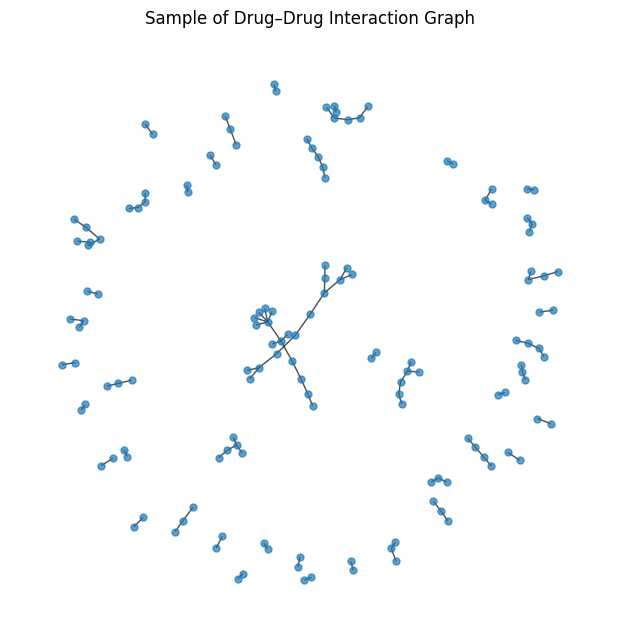

Summary:
Total triples: 4649441
Unique drugs: 645
Unique side effects: 1317
Baseline accuracy (most frequent SE): 0.0062
Figures saved to Google Drive.


In [2]:
# =============================================================
#  Decagon Data Exploration and Simple Baseline
#  Author: Chi Zhang
#  Project: Polypharmacy Side-Effect Prediction
# =============================================================

# STEP 1: Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx
import tarfile

#step 3
import pandas as pd
# Load the CSV (comma separated)
path = '/content/drive/MyDrive/decagon/bio-decagon-combo.csv'
# Read first four columns
df = pd.read_csv(path)
combo = df[['STITCH 1', 'STITCH 2', 'Polypharmacy Side Effect']]
combo.columns = ['drug1', 'drug2', 'side_effect']

# Check first few rows
combo.head()

# STEP 5: Basic statistics
n_edges = len(combo)
n_drugs = pd.unique(combo[['drug1', 'drug2']].values.ravel()).shape[0]
n_side = combo['side_effect'].nunique()

print("Number of drug–drug–side-effect triples:", n_edges)
print("Number of unique drugs:", n_drugs)
print("Number of unique side-effect types:", n_side)

#STEP 6: Visualize top 10 most frequent side effects
top_side = combo['side_effect'].value_counts().head(10)

plt.figure(figsize=(8,4))
top_side.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Side effect type')
plt.ylabel('Count')
plt.title('Top 10 Most Frequent Side Effects')
plt.tight_layout()
plt.show()

# Optional: Save the figure for milestone report
plt.savefig('/content/drive/MyDrive/decagon/top10_side_effects.png', dpi=300)
print("Figure saved to Drive.")

# STEP 7: Implement a simple baseline
# Idea: Always predict the most frequent side effect found in the training data.

# Split dataset into train and validation
train, val = train_test_split(combo, test_size=0.2, random_state=42)
# Find the most common side effect in training data
most_common_se = train['side_effect'].value_counts().idxmax()
print("Most frequent side effect:", most_common_se)
# Predict the same side effect for all validation samples
y_true = val['side_effect'].values
y_pred = [most_common_se] * len(val)
# Evaluate accuracy
acc = accuracy_score(y_true, y_pred)
print("Baseline accuracy:", round(acc, 4))

# STEP 8: (Optional) Draw a small sample subgraph for visualization
# This figure can be used to show the graph structure in the milestone report.
sample = combo.sample(100)
G = nx.from_pandas_edgelist(sample, 'drug1', 'drug2')

plt.figure(figsize=(6,6))
nx.draw(G, node_size=25, alpha=0.7)
plt.title('Sample of Drug–Drug Interaction Graph')
plt.show()

# STEP 9: Summary output for milestone report
print("=================================================")
print("Summary:")
print(f"Total triples: {n_edges}")
print(f"Unique drugs: {n_drugs}")
print(f"Unique side effects: {n_side}")
print(f"Baseline accuracy (most frequent SE): {round(acc, 4)}")
print("Figures saved to Google Drive.")
print("=================================================")



Encode IDs for RESCAL

In [3]:


all_drugs = pd.unique(combo[['drug1', 'drug2']].values.ravel())
drug2id = {d: i for i, d in enumerate(all_drugs)}
id2drug = {i: d for d, i in drug2id.items()}

all_se = combo['side_effect'].unique()
se2id = {s: i for i, s in enumerate(all_se)}
id2se = {i: s for s, i in se2id.items()}

combo['head'] = combo['drug1'].map(drug2id)
combo['tail'] = combo['drug2'].map(drug2id)
combo['rel'] = combo['side_effect'].map(se2id)

print(combo[['head', 'rel', 'tail']].head())
print("Num drugs:", len(drug2id))
print("Num relations:", len(se2id))




   head  rel  tail
0     0    0     1
1     0    1     1
2     0    2     1
3     0    3     1
4     0    4     1
Num drugs: 645
Num relations: 1317


In [4]:
import numpy as np
from scipy.sparse import coo_matrix

num_drugs = len(drug2id)
num_rels = len(se2id)

X = []

for r in range(num_rels):
    sub = combo[combo['rel'] == r]
    rows = sub['head'].values
    cols = sub['tail'].values
    data = np.ones(len(sub))

    mat = coo_matrix((data, (rows, cols)), shape=(num_drugs, num_drugs))
    X.append(mat)

print("Number of relation matrices:", len(X))
print("Shape of each matrix:", X[0].shape)

Number of relation matrices: 1317
Shape of each matrix: (645, 645)


In [5]:
import numpy as np

# Positive triple
positives = combo[['head', 'rel', 'tail']].to_numpy().astype(np.int64)

# Negative Sampling Function
def negative_sampling(triples, num_entities, neg_ratio=1):
    pos_list = triples.tolist()
    neg_list = []
    rng = np.random.default_rng(42)

    for (h, r, t) in pos_list:
        for _ in range(neg_ratio):
            t_neg = rng.integers(0, num_entities)
            neg_list.append([h, r, int(t_neg)])

    return np.array(neg_list, dtype=np.int64)

neg_ratio = 1
negatives = negative_sampling(positives, num_drugs, neg_ratio)

# Compile Training Labels
y_pos = np.ones(len(positives), dtype=np.float32)
y_neg = np.zeros(len(negatives), dtype=np.float32)

X_all = np.vstack([positives, negatives])
y_all = np.concatenate([y_pos, y_neg])

print("Total samples:", X_all.shape)

Total samples: (9298882, 3)


In [6]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

class TripleDataset(Dataset):
    def __init__(self, triples, labels):
        self.triples = torch.from_numpy(triples).long()
        self.labels = torch.from_numpy(labels).float()

    def __len__(self):
        return self.triples.shape[0]

    def __getitem__(self, idx):
        h, r, t = self.triples[idx]
        y = self.labels[idx]
        return h, r, t, y

batch_size = 4096

train_loader = DataLoader(
    TripleDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    TripleDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False
)

print("Train size:", len(train_loader.dataset))
print("Test size :", len(test_loader.dataset))

Train size: 7439105
Test size : 1859777


In [7]:
import torch.nn as nn

class RESCALModel(nn.Module):
    def __init__(self, num_entities, num_relations, rank):
        super().__init__()
        self.rank = rank
        self.entity_emb = nn.Embedding(num_entities, rank)
        self.rel_emb = nn.Embedding(num_relations, rank * rank)

        nn.init.xavier_uniform_(self.entity_emb.weight.data)
        nn.init.xavier_uniform_(self.rel_emb.weight.data)

    def forward(self, h, r, t):
        h_e = self.entity_emb(h)
        t_e = self.entity_emb(t)
        r_m = self.rel_emb(r).view(-1, self.rank, self.rank)

        hr = torch.bmm(h_e.unsqueeze(1), r_m)
        score = torch.bmm(hr, t_e.unsqueeze(2)).squeeze()
        return score

In [8]:
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

rank = 64
model = RESCALModel(num_drugs, num_rels, rank).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for h, r, t, y in train_loader:
        h = h.to(device)
        r = r.to(device)
        t = t.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        scores = model(h, r, t)
        loss = criterion(scores, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * h.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} - Train loss: {avg_loss:.4f}")

Using device: cuda
Epoch 1/3 - Train loss: 0.4924
Epoch 2/3 - Train loss: 0.4253
Epoch 3/3 - Train loss: 0.3979


In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score

model.eval()
all_scores, all_labels = [], []

with torch.no_grad():
    for h, r, t, y in test_loader:
        h = h.to(device)
        r = r.to(device)
        t = t.to(device)

        scores = model(h, r, t)
        all_scores.append(scores.cpu().numpy())
        all_labels.append(y.numpy())

all_scores = np.concatenate(all_scores)
all_labels = np.concatenate(all_labels)

auroc = roc_auc_score(all_labels, all_scores)
aupr  = average_precision_score(all_labels, all_scores)

print("PyTorch RESCAL Results")
print("Test AUROC:", round(auroc, 4))
print("Test AUPR :", round(aupr, 4))

PyTorch RESCAL Results
Test AUROC: 0.8717
Test AUPR : 0.8342


In [10]:
import numpy as np
import torch

# A: (num_drugs, rank=64)
A = model.entity_emb.weight.detach().cpu().numpy()
print(A.shape)

(645, 64)


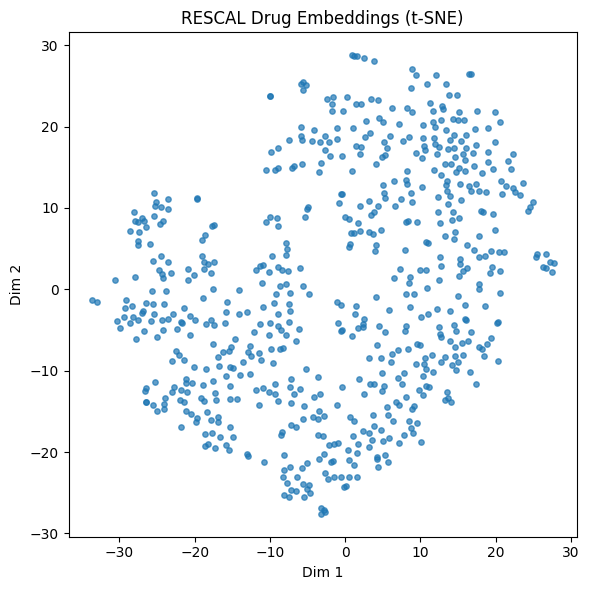

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42,
)
A_2d = tsne.fit_transform(A)   # (645, 2)

plt.figure(figsize=(6, 6))
plt.scatter(A_2d[:, 0], A_2d[:, 1], s=15, alpha=0.7)
plt.title("RESCAL Drug Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

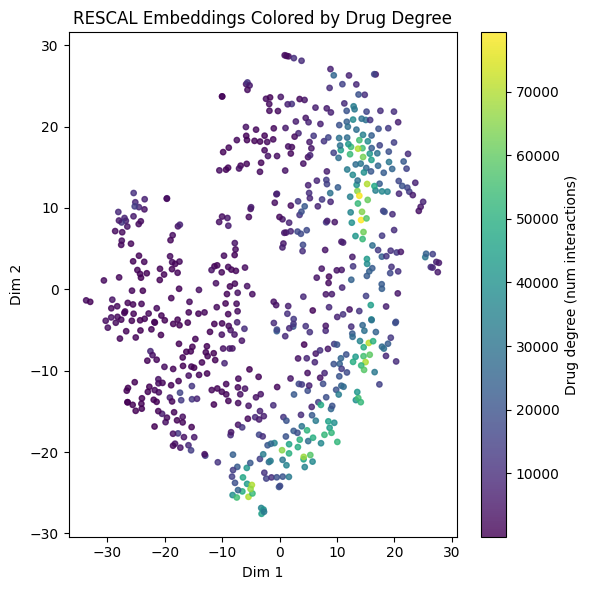

In [12]:
# Calculate the number of occurrences (degree) for each drug
deg_drug1 = combo['head'].value_counts()
deg_drug2 = combo['tail'].value_counts()
deg = deg_drug1.add(deg_drug2, fill_value=0)  # Series: index=drug_id
deg = deg.reindex(range(A.shape[0]), fill_value=0).to_numpy()

plt.figure(figsize=(6, 6))
sc = plt.scatter(A_2d[:, 0], A_2d[:, 1],
                 c=deg, s=15, alpha=0.8)
plt.colorbar(sc, label="Drug degree (num interactions)")
plt.title("RESCAL Embeddings Colored by Drug Degree")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

multi-class RESCAL

In [14]:
triples = combo[['head', 'rel', 'tail']].to_numpy().astype(np.int64)
print(triples.shape)   # (N, 3)

(4649441, 3)


In [19]:

X = combo[['head', 'tail']].to_numpy().astype(np.int64)   # shape (N, 2)
y = combo['rel'].to_numpy().astype(np.int64)              # shape (N,)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class PairRelDataset(Dataset):
    def __init__(self, pairs, rels):
        self.pairs = torch.from_numpy(pairs).long()
        self.rels  = torch.from_numpy(rels).long()

    def __len__(self):
        return self.pairs.shape[0]

    def __getitem__(self, idx):
        h, t = self.pairs[idx]
        r = self.rels[idx]
        return h, t, r

batch_size = 2048

train_loader = DataLoader(
    PairRelDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    PairRelDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False
)

print("Train size:", len(train_loader.dataset))
print("Test size :", len(test_loader.dataset))

Train size: 3719552
Test size : 929889


In [21]:
import torch.nn as nn
import torch

class RESCALMulti(nn.Module):
    def __init__(self, num_entities, num_relations, rank, chunk_size=64):
        super().__init__()
        self.rank = rank
        self.num_relations = num_relations
        self.chunk_size = chunk_size

        self.entity_emb = nn.Embedding(num_entities, rank)
        self.rel_emb = nn.Embedding(num_relations, rank * rank)

        nn.init.xavier_uniform_(self.entity_emb.weight)
        nn.init.xavier_uniform_(self.rel_emb.weight)

    def forward(self, h, t):
      """
       h, t: (B,)
       return: logits (B, num_relations)
      """
      B = h.size(0)

      h_e = self.entity_emb(h)      # (B, k)
      t_e = self.entity_emb(t)      # (B, k)

      logits = []

      # Calculate by relation block
      for start in range(0, self.num_relations, self.chunk_size):
          end = min(start + self.chunk_size, self.num_relations)

          R_chunk = self.rel_emb.weight[start:end].view(
              end - start, self.rank, self.rank
          )                           # (C, k, k)

          # (B, k) x (C, k, k) → (B, C, k)
          hr = torch.einsum("bk,ckl->bcl", h_e, R_chunk)

          # (B, C, k) x (B, k) → (B, C)
          score_chunk = torch.einsum("bck,bk->bc", hr, t_e)

          logits.append(score_chunk)

      return torch.cat(logits, dim=1)   # (B, R)



In [22]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

rank = 64
model = RESCALMulti(num_drugs, num_rels, rank).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for h, t, r in train_loader:
        h = h.to(device)
        t = t.to(device)
        r = r.to(device)

        optimizer.zero_grad()
        logits = model(h, t)
        loss = criterion(logits, r)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * h.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} - Train loss: {avg_loss:.4f}")

Using device: cuda
Epoch 1/3 - Train loss: 6.4311
Epoch 2/3 - Train loss: 6.2436
Epoch 3/3 - Train loss: 6.1459


In [23]:
def topk_accuracy(logits, targets, k):
    """
    logits: (N, num_rels)
    targets: (N,)
    """
    topk = torch.topk(logits, k=k, dim=1).indices
    correct = topk.eq(targets.view(-1, 1)).any(dim=1)
    return correct.float().mean().item()


In [24]:
model.eval()

all_logits = []
all_targets = []

with torch.no_grad():
    for h, t, r in test_loader:
        h = h.to(device)
        t = t.to(device)

        logits = model(h, t)
        all_logits.append(logits.cpu())
        all_targets.append(r)

all_logits = torch.cat(all_logits, dim=0)
all_targets = torch.cat(all_targets, dim=0)

top1  = topk_accuracy(all_logits, all_targets, k=1)
top5  = topk_accuracy(all_logits, all_targets, k=5)
top10 = topk_accuracy(all_logits, all_targets, k=10)

print("RESCAL Multi-class Results")
print(f"Top-1  Acc: {top1:.4f}")
print(f"Top-5  Acc: {top5:.4f}")
print(f"Top-10 Acc: {top10:.4f}")

RESCAL Multi-class Results
Top-1  Acc: 0.0048
Top-5  Acc: 0.0255
Top-10 Acc: 0.0518


In [25]:
A = model.entity_emb.weight.detach().cpu().numpy()
print(A.shape)

(645, 64)


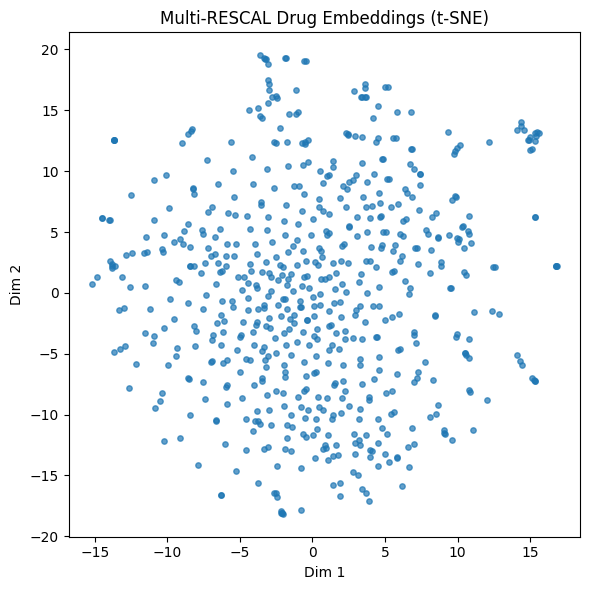

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42,
)

A_2d = tsne.fit_transform(A)

plt.figure(figsize=(6, 6))
plt.scatter(A_2d[:, 0], A_2d[:, 1], s=15, alpha=0.7)
plt.title("Multi-RESCAL Drug Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

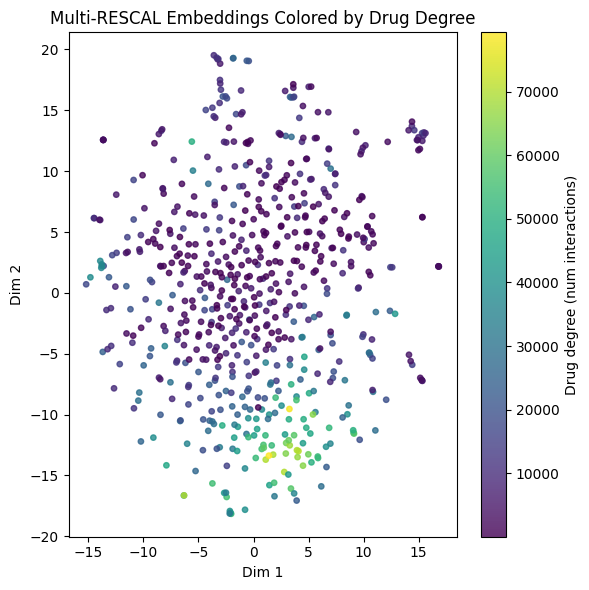

In [27]:
# Calculate the degree for each drug
deg_drug1 = combo['head'].value_counts()
deg_drug2 = combo['tail'].value_counts()

deg = deg_drug1.add(deg_drug2, fill_value=0)
deg = deg.reindex(range(A.shape[0]), fill_value=0).to_numpy()

# t-SNE scatter with degree coloring
plt.figure(figsize=(6, 6))
sc = plt.scatter(
    A_2d[:, 0],
    A_2d[:, 1],
    c=deg,
    s=15,
    alpha=0.8
)

plt.colorbar(sc, label="Drug degree (num interactions)")
plt.title("Multi-RESCAL Embeddings Colored by Drug Degree")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()